<a href="https://colab.research.google.com/github/Heyymant/Portfolio-Optimization-/blob/main/Portfolio_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install pyopt.client
!pip install fake_useragent

In [19]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize  as sci_opt
from fake_useragent import UserAgent

from sklearn.preprocessing import StandardScaler
from pprint import pprint
from client import PriceHistory


# Set some display options for Pandas.
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

<ipython-input-19-d13e8d3768b7>:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [5]:
# Symbols of related stocks
symbols = ["AAPL", "MSFT" , "SQ", "AMZN"]

# number of stocks in portfolio
number_of_symbols  = len(symbols)


# grabbing the data from live nasdaq
# we are also adding the code if we already have a file path

# if the file path does not exists then we can grab the data dynamically from the NASDAQ portal
if not pathlib.Path(r"./stock_data.csv"). exists():

    # initializing the price history client
    price_history_client = PriceHistory(
        symbols = symbols,
        user_agent = UserAgent().edge
        )


    # grabbing the data and dumping it into a csv file
    price_history_client.price_data_frame.to_csv(
        "./stock_data.csv",
        index = False
    )

    display(price_history_client.price_data_frame)

    price_df: pd.DataFrame = price_history_client.price_data_frame

else:

    # loading the existing data file
    price_df: pd.DataFrame = pd.read_csv('./stock_data.csv')


# printing the extracted dataframe
pprint(price_df.head())



,date,close,volume,open,high,low,symbol
0,2024-02-06,169.15,42505520,169.39,170.71,167.65,AMZN
1,2024-02-05,170.31,55081300,170.20,170.55,167.70,AMZN
2,2024-02-02,171.81,117218300,169.19,172.50,167.33,AMZN
3,2024-02-01,159.28,76542420,155.87,159.76,155.62,AMZN
4,2024-01-31,155.20,50284370,157.00,159.01,154.81,AMZN
...,...,...,...,...,...,...,...
503,2023-08-11,177.79,52036670,177.32,178.62,176.55,AAPL
504,2023-08-10,177.97,54686850,179.48,180.75,177.60,AAPL
505,2023-08-09,178.19,60378490,180.87,180.93,177.01,AAPL
506,2023-08-08,179.80,67823000,179.69,180.27,177.58,AAPL


        date   close     volume    open    high     low symbol
0 2024-02-06  169.15  42505520   169.39  170.71  167.65  AMZN 
1 2024-02-05  170.31  55081300   170.20  170.55  167.70  AMZN 
2 2024-02-02  171.81  117218300  169.19  172.50  167.33  AMZN 
3 2024-02-01  159.28  76542420   155.87  159.76  155.62  AMZN 
4 2024-01-31  155.20  50284370   157.00  159.01  154.81  AMZN 


In [6]:
# Cleaning the data set and grabbing the required info

# getting the required columns
price_df = price_df[["date" , "close", "symbol"]]

# Pivoting the data frame

price_df = price_df.pivot(
    index = "date",
    values = "close",
    columns = "symbol"
)

In [7]:

display(price_df)

symbol,AAPL,AMZN,MSFT,SQ
date,,,,
2023-08-07,178.85,142.22,330.11,64.01
2023-08-08,179.80,139.94,326.05,62.38
2023-08-09,178.19,137.85,322.23,62.71
2023-08-10,177.97,138.56,322.93,62.24
2023-08-11,177.79,138.41,321.01,60.57
...,...,...,...,...
2024-01-31,184.40,155.20,397.58,65.01
2024-02-01,186.86,159.28,403.78,66.67
2024-02-02,185.85,171.81,411.22,67.88


Now we have to set some parameter to define the risk and actually optimize our portfolio. Here we are using the Sharpe Ratio as parameter to quantify risk and returns.

 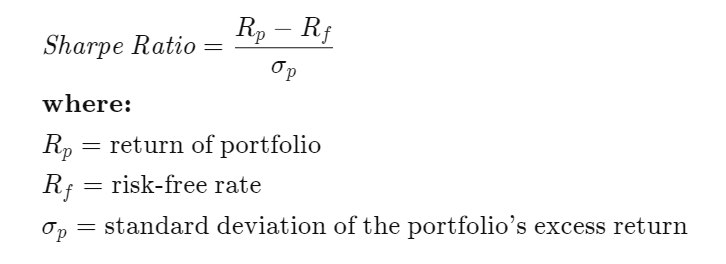

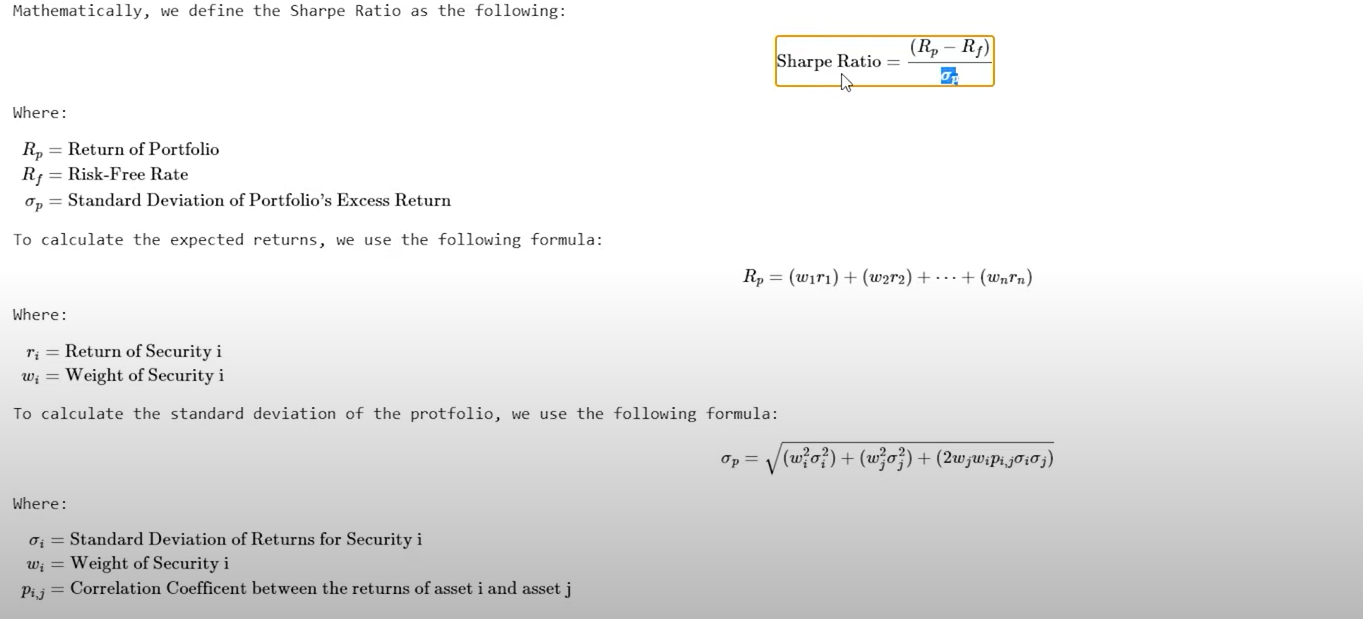

In [8]:
# taking log of the returns
log_returns = np.log(1+ price_df.pct_change())


# generate some random weights
random_weights = np.array(np.random.random(len(symbols)))

rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_returns.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_returns.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0  0.688724        0.262971         
1  0.849070        0.324195         
2  0.986542        0.376685         
3  0.094677        0.036150         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0  0.30055                     0.191135                       1.572453              
--------------------------------------------------------------------------------


In [9]:
display(log_returns.cov())

symbol,AAPL,AMZN,MSFT,SQ
symbol,,,,
AAPL,0.000148,0.000109,0.000085,0.000133
AMZN,0.000109,0.000345,0.000130,0.000194
MSFT,0.000085,0.000130,0.000148,0.000080
SQ,0.000133,0.000194,0.000080,0.000820


# **Portfolio Optimzation: Monte Carlo**
Great, so we now have a way to evaluate how well our portfolio is allocated. It involves, calculating the expected returns, the expected volatility, and then from here we use the Sharpe Ratio to quantify how well our portfolio is allocated based on a risk perspective. The big question here is, "If we know that we want to get a higher sharpe ratio, what is the portfolio allocation we need to achieve this?"

Well, there are two ways to approach this. First, we could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio. Second, we could use mathematical optimization defined by some constrains to arrive at the optimial allocation. In the next section, we will run the "try a bunch of random allocations" method. Now, there is a more formal name for this process, a Monte Carlo Simulation.

In [10]:
# Defining the numner of iterations
num_of_portfolios = 3000


# storage of weights in each iteration
all_weights = np.zeros((num_of_portfolios, len(symbols)))

# preppping the returns array
ret_arr = np.zeros(num_of_portfolios)

# prepping the Volatility array
vol_arr = np.zeros(num_of_portfolios)

# prepping the sharpe ratio array
sharpe_arr = np.zeros(num_of_portfolios)


# Start the simulation

for i in range(num_of_portfolios):

    # first calculate the weights
    weights = np.array(np.random.random(len(symbols)))
    weights = weights/np.sum(weights)

    # storing the weights of each turn
    all_weights[i, :] = weights

    # calculate the expected log returns
    ret_arr[i] = np.sum((log_returns.mean()*weights)*252)

    # calculate the volatility,
    vol_arr[i] = np.sqrt(
        np.dot(weights.T , np.dot(log_returns.cov()*252 , weights))
    )

    # calculate sharpe ratio
    sharpe_arr[i] = ret_arr[i] /vol_arr[i]

# the collection of all the data parameters we just calculated
simulations_data = [ret_arr ,vol_arr , sharpe_arr , all_weights]

# converting in into a dataframe
simulations_df = pd.DataFrame(data = simulations_data).T

# naming the columns

simulations_df.columns = [
    "Returns",
    "Volatility",
    "Sharpe Ratio",
    "Portfolio Weights"
]


# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0  0.214571  0.248633    0.863004      [0.1849284534816074, 0.08377042735130952, 0.30541200099215626, 0.4258891181749268]  
1  0.234282  0.179532    1.304965      [0.5033192841716219, 0.17168979861375486, 0.2746595826665101, 0.050331334548113234] 
2  0.203232  0.249139    0.815740      [0.2723691982840954, 0.400168135161045, 0.011288240409173405, 0.3161744261456863]   
3  0.259607  0.227298    1.142145      [0.12410580417671001, 0.23047663975259577, 0.33323675509788353, 0.31218080097281065]
4  0.308821  0.202149    1.527689      [0.10753307053760848, 0.28057847730676144, 0.4481652321365946, 0.16372322001903541] 
--------------------------------------------------------------------------------


# **Grabbing the important metrices we need**

1.   ``` max_sharpe_ratio ``` the sharpe ratio where the excess return of the portfolio is greatest given  the amount of risk we are taking on it.

2.   ``` min_volatility ``` these are the weights where the overall volatility of the portfolio is at its lowest, we can use these weights to minimize our risks.  




In [11]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

# Returning the max _returns metrices
max_returns = simulations_df.loc[simulations_df["Returns"].idxmax()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)

print('')
print('='*80)
print('MAX RETURNS:')
print('-'*80)
print(max_returns)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.391131                                                                            
Volatility           0.189855                                                                            
Sharpe Ratio         2.060157                                                                            
Portfolio Weights    [0.02533769762535305, 0.13165418356992897, 0.8299779756487867, 0.013030143155931132]
Name: 2716, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.273375                                                                              
Volatility           0.17146                                                                               
Sharpe Ratio         1.594393                          

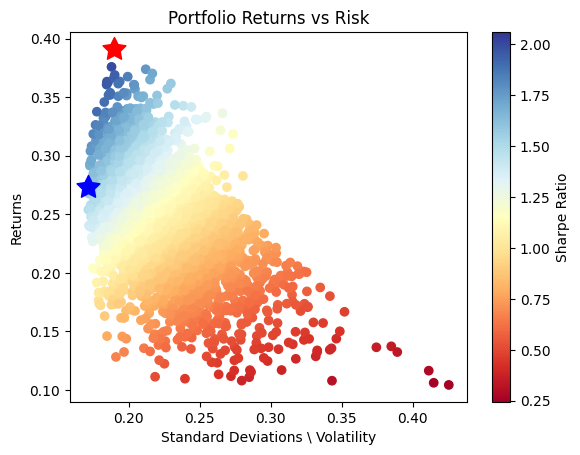

In [12]:
%matplotlib inline

# ploting the returns vs volatility graph
plt.scatter(
    y = simulations_df["Returns"],
    x = simulations_df["Volatility"],
    c = simulations_df["Sharpe Ratio"],
    cmap = "RdYlBu"
)

# adding details to the plot
plt.title("Portfolio Returns vs Risk")
plt.colorbar(label = "Sharpe Ratio")
plt.xlabel("Standard Deviations \ Volatility")
plt.ylabel("Returns")


# Adding a marker for max Sharpe Ratio
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker = (5 ,1 ,0 ),
    color = 'r',
    s = 300
)

# plotting a marker for min Volatility
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker = (5,1,0),
    color = 'b',
    s = 300
)

plt.show()

## Optimization

Alright, now remember that up above I mentioned that we would be exploring multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.

To help run this new optimization method, we will need to define a few more functions that we will use in our method. The first function is the get_metrics() function which will return the metrics for a given set of weights provided. In other words, think of it as a "lookup function" where we can return the results of a certain weight. The second function is the neg_sharpe function which is used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no maximize, so as an objective function you need to pass something that should be minimized.

The third function is check_sum function which is used as a constraint. What is will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [13]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """
    # convert to a numpy array
    weights = np.array(weights)

    # calculate the returns, remember to annual them(252)
    ret = np.sum(log_returns.mean() * weights) *252

    # calculate the volatility, remember to annualize them
    volt = np.sqrt(
        np.dot(weights.T , np.dot(log_returns.cov() *252 , weights))
    )

    # calculate the sharpe ratio
    sr = ret / volt

    return np.array([ret ,volt ,sr])

def grab_negative_sharpe(weights: list ) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.

    """
    return get_metrics(weights)[2] -1

def grab_volatility(weights : list) -> np.array :
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights : list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.

    """
    return np.sum(weights) - 1

Okay with our functions now defined, let's run the optimization using the scipy.optimization module. This module has a function called minimize which we can use to help our optimial values. However, we need to do a few things before we run it. First, we need to define bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation. Second, we need to define the constraint which will be a fun(function) that ensures we equ(equal) a 100% allocated portfolio. In other words, we use all the "capital" we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case let's make it easy and start with an equally distirbuted portofolio. In this case we have 4 symbols so each symbol will be 25% of the portfolio.

Once we've define this steps we can run the optimization by passing through the arguments defined and defining the method as SLSQP which is short for Sequential Least Squares Programming. Now, the different optimization methods are a whole different topic and is outside the scope of this tutorial. Once we run the minimize method we can grab the results.

The first is the results of our minimization operation. Inside the results, you'll see the optimize sharpe ration defined by the fun value. We can then take the optimized_weights defined by the optimized_sharpe.x values, and use them to return the different metrics we have for our portfolio.

In [20]:
# defining the boundaries for each symbol since we can only invest upto 100% of the total capital into a single asset
bounds = tuple((0 ,1) for symbol in range(len(symbols)))

# alsd defining the constraints to make sure weights does not exceed 100%
constraints =  ({'type':  "eq" , "fun" :check_sum})

# we need to create an inital guess to start the process
init_guess = number_of_symbols * [1/ number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7991875220979597
       x: [ 1.388e-16  0.000e+00  6.939e-16  1.000e+00]
     nit: 2
     jac: [ 2.172e-01  7.153e-01  8.851e-01  7.451e-09]
    nfev: 10
    njev: 2
--------------------------------------------------------------------------------


In [21]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1.38777878e-16 0.00000000e+00 6.93889390e-16 1.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.0913066  0.45468587 0.20081248]
--------------------------------------------------------------------------------


In [22]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1712767473825783
       x: [ 4.907e-01  7.589e-19  4.950e-01  1.439e-02]
     nit: 6
     jac: [ 1.719e-01  1.774e-01  1.707e-01  1.710e-01]
    nfev: 31
    njev: 6
--------------------------------------------------------------------------------


In [23]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[4.90656639e-01 7.58941521e-19 4.94958064e-01 1.43852974e-02]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.26063426 0.17127675 1.52171418]
--------------------------------------------------------------------------------


In [24]:
np.sum(optimized_volatility.x)

1.0